## RL for Predictive Maintenance
- 07-Dec-24: PHM: All C01, C04 and C06 x three runs done W8
- 



In [16]:
## Working PHM settings
# - EARLY_DETECT_FACTOR = -0.125
# - r1 = 1; r2 = -4; r3 = -0.5
# - ADD_NOISE = 5*1e2
# - SAMPLING_RATE = 25
# - EPISODES = 200 k

## Working NUAA settings
# - EARLY_DETECT_FACTOR = -0.10
# - r1 = 1; r2 = -4; r3 = -0.5
# - ADD_NOISE = 5*1e2
# - SAMPLING_RATE = 25
# - EPISODES = 200 k

In [17]:
# PHM EARLY_DETECT_FACTOR = -0.125
# PHM r1 = 1; r2 = -4; r3 = -0.5

## NUAA 
EARLY_DETECT_FACTOR = -0.125
r1 = 2; r2 = -4; r3 = -0.5

ENV_TYPE = 'NUAA' # PHM 
TRAINING_DATA = f'{ENV_TYPE}_W1' # C01, C04, C06, W1, W3, W8 
ADD_NOISE = 5*1e2
SAMPLING_RATE = 25
EPISODES = 300_000

## Milling Tool Environment

In [18]:
# Milling Tool Environment
# - Handles multiple dataset. PHM and NUAA
# - Default Rewards: ```R1: +1.0, R2: -4.0, R3: -0.5```

import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

NO_ACTION = 0
REPLACE = 1

class Milling_Tool_Env(gym.Env):
    
        def __init__(self, max_records=0, env_type = '', rul_threshold=0.0, R1=1.0, R2=0.0, R3=0.0):
            print(f'-- Ver. RB 0.5. Tested 26-Nov-24: Environment: {env_type} | RUL threshold: {rul_threshold:4.3f} | Records: {max_records} | R1: {R1:3.1f}, R2: {R2:3.1f}, R3: {R3:3.1f}')

            # Initialize
            self.env_type = env_type
            self.R1 = R1
            self.R2 = R2
            self.R3 = R3
            self.reward = 0.0
            self.cummulative_rewards = 0.0

            self.a_rewards = []
            self.a_actions = []
            self.a_action_recommended = []
            self.a_rul = []
            self.a_time_since_last_replacement = []

            self.df = None
            self.current_time_step = 0
            self.max_records = max_records
            self.maintenance_cost = 0.0
            self.replacement_events = 0
            self.time_since_last_replacement = 0
            self.rul_threshold = rul_threshold

            high = np.array(6*[1.0], dtype=np.float32)
            low = np.array(6*[-1.0], dtype=np.float32)
            self.observation_space = spaces.Box(low, high, dtype=np.float32)
            self.action_space = spaces.Discrete(2)

        ## Add tool wear data-set
        ## Keep rul_threshold intialized to self.rul_threshold
        def tool_wear_data(self, df, rul_threshold=0.0):
            self.df = df
            self.rul_threshold = rul_threshold
            self.max_records = len(df.index)
            print(f'   * Tool-wear data updated: {self.max_records}. RUL threshold: {self.rul_threshold:4.3f}')

        def _get_observation(self):
            if (self.df is not None):
                if (self.env_type == 'PHM'):
                    obs_values = np.array([
                        self.df.loc[self.current_time_step, 'force_x'],
                        self.df.loc[self.current_time_step, 'force_y'],
                        self.df.loc[self.current_time_step, 'force_z'],
                        self.df.loc[self.current_time_step, 'vibration_x'],
                        self.df.loc[self.current_time_step, 'vibration_y'],
                        self.df.loc[self.current_time_step, 'vibration_z']
                    ], dtype=np.float32)
                else:
                    obs_values = np.array([
                        self.df.loc[self.current_time_step, 'axial_force'],
                        self.df.loc[self.current_time_step, 'force_z'],
                        self.df.loc[self.current_time_step, 'vibration_x'],
                        self.df.loc[self.current_time_step, 'vibration_y'],
                        self.df.loc[self.current_time_step, 'vibration1'],
                        self.df.loc[self.current_time_step, 'vibration2']
                    ], dtype=np.float32)
            else:
                obs_values = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)

            observation = obs_values.flatten()
            return observation

        def _get_auxilliary_info(self):
            if (self.df is not None):
                recommended_action = int(self.df.loc[self.current_time_step, 'ACTION_CODE'])
                rul = float(self.df.loc[self.current_time_step, 'RUL'])
            else:
                recommended_action = 0
                rul = 0.0

            return recommended_action, rul

        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            # self.a_rewards = []
            # self.a_actions = []
            # self.a_action_recommended = []
            # self.a_rul = []

            # Choose the tool wear at a random time (spatial) location from a uniformly random distribution
            # self.current_time_step = np.random.randint(0, int(RANDOM_TOOL_START_OF_LIFE * self.max_records), 1, dtype=int)
            self.current_time_step = 0
            self.reward = 0.0
            self.cummulative_rewards = 0.0

            observation = self._get_observation()
            info = {'reset':'Reset'}
            return observation, info

        ## Step
        def step(self, action):
            terminated = False
            reward = 0.0
            info = {'Step':'-'}
            # Get auxilliary info: current RUL reading (note this is NOT part of the observation) and the expert's recommended action
            recommended_action, self.rul = self._get_auxilliary_info()
            self.maintenance_cost = 0.0

            # Check if Episode over
            if self.current_time_step >= self.max_records:
                done = True

            # Reward for RUL maximized and penalize if breached
            if self.rul > (1.0 + EARLY_DETECT_FACTOR)*self.rul_threshold:
                reward = self.current_time_step*self.R1
            else:
                reward = self.current_time_step*self.R2

            # If tool replaced, add cost of replacement
            if action == REPLACE:
                # Update time_since_last_replacement
                self.time_since_last_replacement = self.current_time_step
                self.a_time_since_last_replacement.append(self.current_time_step)
                reward = self.current_time_step*self.R3
                self.current_time_step = 0

            self.reward = reward
            self.cummulative_rewards = self.cummulative_rewards + reward

            # Information arrays
            self.a_rewards.append(reward)
            self.a_actions.append(action)
            self.a_action_recommended.append(recommended_action)
            self.a_rul.append(self.rul)

            if (action != REPLACE) and (self.current_time_step < (self.max_records-1)):
              self.current_time_step += 1

            # Action taken, reward set for that action, now take in next observation
            observation = self._get_observation()


            if self.rul <= self.rul_threshold:
              self.cummulative_rewards = 0.0

            # if self.rul > self.rul_threshold:
            #     print(f'Action>> Expert:{recommended_action:2d} Agent:{action:2d}| RUL: {self.rul:>5.2f} | Reward: {reward:>7.2f} -- CR: {self.cummulative_rewards:>7.2f}' )
            # else:
            #     print(f'*** RUL reached: {self.rul:3.2f} ***')
            #     self.cummulative_rewards = 0.0

            # writer.add_scalar('reward', reward)
            return observation, self.reward, terminated, False, info

## Libraries, Paths, Data-sets

In [19]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# RL libraries
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from torch.utils.tensorboard import SummaryWriter

# Custom libraries
from utilities import downsample, tool_wear_data

# Data-sets
datasets = {'NUAA_W1':['NUAA_W1_0p229.csv', 0.229], 'NUAA_W3':['NUAA_W3_0p12.csv', 0.12], 'NUAA_W8':['NUAA_W8_0p281.csv', 0.281],
           'PHM_C01':['PHM_C01_0p12.csv', 0.12],  'PHM_C04':['PHM_C04_0p098.csv', 0.098],  'PHM_C06':['PHM_C06_0p13.csv', 0.13]}

# Paths
dt_string = datetime.now().strftime("%d-%b-%Y  %H:%M:%S")
PATH = 'D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance'
DATA_PATH = f'{PATH}/Data/'

## Set-up

In [20]:
# # Environment set-up
ENV_TYPE = 'NUAA' # PHM 
# TRAINING_DATA = f'{ENV_TYPE}_W3' # C01, C04, C06, W1, W3, W8 
EVALUATION_DATA = f'{ENV_TYPE}_W3'
# ADD_NOISE = 5*1e2
# SAMPLING_RATE = 50

# # RL set-up
# EPISODES = int(100e3)
ALGO = 'PPO'
BATCH_SIZE = 16
EVALUATION_ROUNDS = 20
TENSOR_BOARD = True
PRETRAINED_MODEL = False 
MAX_EPISODE_STEPS_FACTOR = 10 # MAX_EPISODE_STEPS = MAX_EPISODE_STEPS_FACTOR*records

# Set-up data-sets
DATA_FILE = datasets[TRAINING_DATA][0]
WEAR_THRESHOLD = datasets[TRAINING_DATA][1]
TEST_DATA = datasets[EVALUATION_DATA][0]
TEST_WEAR_THRESHOLD = datasets[EVALUATION_DATA][1]

# Paths
DATA_FILE = f'{DATA_PATH}/{DATA_FILE}'
TEST_DATA_FILE = f'{DATA_PATH}/{TEST_DATA}'
mfile = f'Agent_{TRAINING_DATA}_Eps_{EPISODES}_Noise_{ADD_NOISE}_R1_{r1}_R2_{r2}_R3_{r3}'
mfile = mfile.replace('.', 'p')
MODEL_FILE = f'{PATH}/models/{mfile}'
LOG_PATH = f'{PATH}/tensorboard/{TRAINING_DATA}/'

writer = SummaryWriter(LOG_PATH) if TENSOR_BOARD else None 
print(f'TRAINING: Data set: {DATA_FILE}, Threshold: {WEAR_THRESHOLD}')
print(f'EVALUATION: Data set: {TEST_DATA}, Threshold: {TEST_WEAR_THRESHOLD}')
print(f'Tensorboard logging to {LOG_PATH}')
print(f'Model {MODEL_FILE}')

TRAINING: Data set: D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/Data//NUAA_W8_0p281.csv, Threshold: 0.281
EVALUATION: Data set: NUAA_W3_0p12.csv, Threshold: 0.12
Tensorboard logging to D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/tensorboard/NUAA_W8/
Model D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/models/Agent_NUAA_W8_Eps_200000_Noise_500p0_R1_2_R2_-4_R3_-0p5


## Tool wear data

- Down-sampling. Input data records: 1008. Sampling rate: 25. Expected rows 40.    Down-sampled to 41 rows.


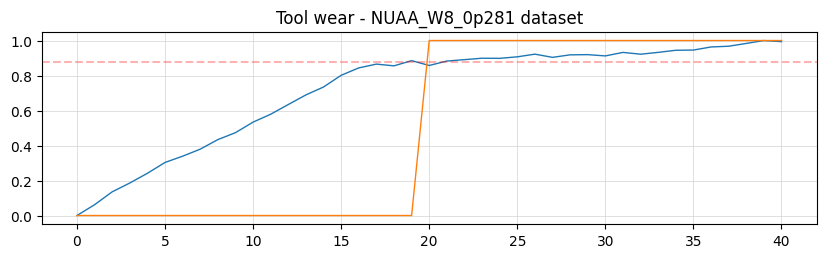

- Down-sampling. Input data records: 901. Sampling rate: 25. Expected rows 36.    Down-sampled to 37 rows.


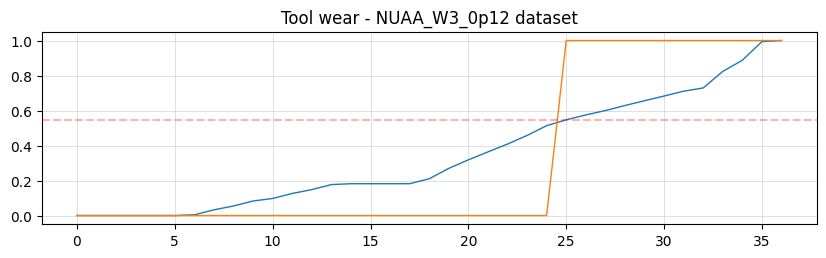

TRAIN - RUL threshold at time 19 is 0.133, and wear threshold 0.281
TEST  - RUL threshold at time 25 is 0.453, and wear threshold 0.120


In [21]:
# Create Training data
_, _, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    env_type = ENV_TYPE, data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MAX_EPISODE_STEPS = MAX_EPISODE_STEPS_FACTOR*records
rul_threshold_record_train = df_train.loc[df_train['tool_wear'] >= WEAR_THRESHOLD_NORMALIZED].index[0]
rul_threshold_train = df_train.loc[df_train.index[rul_threshold_record_train], 'RUL']

# Create Test data
_, _, TEST_WEAR_THRESHOLD_NORMALIZED, df_test = tool_wear_data(
    env_type = ENV_TYPE, data_file=TEST_DATA_FILE, wear_threshold = TEST_WEAR_THRESHOLD,
    normalize=True, add_noise=False, sampling_rate = SAMPLING_RATE)

n_test_records = len(df_test.index)
rul_threshold_record_test = df_test.loc[df_test['tool_wear'] >= TEST_WEAR_THRESHOLD_NORMALIZED].index[0]
rul_threshold_test = df_test.loc[df_test.index[rul_threshold_record_test], 'RUL']

print(f'TRAIN - RUL threshold at time {rul_threshold_record_train} is {rul_threshold_train:3.3f}, and wear threshold {WEAR_THRESHOLD:3.3f}')
print(f'TEST  - RUL threshold at time {rul_threshold_record_test} is {rul_threshold_test:3.3f}, and wear threshold {TEST_WEAR_THRESHOLD:3.3f}')

## Predictive Maintenance Agent Training

In [22]:
from stable_baselines3.common.monitor import Monitor

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = Milling_Tool_Env,
    max_episode_steps = MAX_EPISODE_STEPS,)

mt_env = Monitor(gym.make('custom/MillingToolEnv-v0', max_records=records, env_type=ENV_TYPE, rul_threshold=rul_threshold_train, R1=r1, R2=r2, R3=r3))
# mt_env = gym.make('custom/MillingToolEnv-v0', max_records=records, env_type=ENV_TYPE, rul_threshold=rul_threshold_train)
mt_env.tool_wear_data(df_train, rul_threshold_train)

-- Ver. RB 0.5. Tested 26-Nov-24: Environment: NUAA | RUL threshold: 0.133 | Records: 41 | R1: 2.0, R2: -4.0, R3: -0.5
   * Tool-wear data updated: 41. RUL threshold: 0.133


In [23]:
if ALGO == 'PPO':
    expert_ppo = PPO('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
    expert_ppo.learn(EPISODES)
    expert = expert_ppo
elif ALGO == 'A2C':
    expert_a2c = A2C('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
    expert_a2c.learn(EPISODES)
    expert = expert_a2c

## SKIP EXECTUION

In [31]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [32]:
%%skip

dts = datetime.now().strftime("%d-%b-%Y_%H_%M_%S")
dt = datetime.now().strftime("%d-%b-%Y")

print(f'- Saving Expert model in {mfile}')
MODEL_FILE = f'{PATH}/models/{dt}/{mfile}_{dts}'

MODEL_FILE = MODEL_FILE.replace('.', 'p')
print(f'- Saving Expert model in {MODEL_FILE}')
expert.save(MODEL_FILE)

In [33]:
%%skip

def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [34]:
%%skip

stop_pt = int(1 * len(mt_env.a_rul))
w = 1000
ma_rul = moving_average(mt_env.a_rul[0:stop_pt], w)
# ma_rul = np.pad(ma_rul, pad_width=w, mode='edge')
plt.figure(figsize=(30, 2.5))
# plt.plot(mt_env.a_rul[0:stop_pt], 'powderblue', alpha=0.7)
plt.plot(ma_rul[:-w], 'slateblue')
title = f'Remaining Useful Life - [{TRAINING_DATA}. Threshold {rul_threshold_train:4.3f}]'
plt.title(title)
# plt.axhline(y = rul_threshold_train, color = 'b', linestyle = '--', alpha=0.3)
# plt.axhline(y = WEAR_THRESHOLD_NORMALIZED, color = 'r', linestyle = '--', alpha=0.3)
IMAGE_FILE = f'{PATH}/models/{dt}/RUL_{dts}.png'
plt.savefig(IMAGE_FILE, bbox_inches='tight')
plt.show()

stop_pt = int(1 * len(mt_env.a_time_since_last_replacement))
w = 100
ma_rep_time = moving_average(mt_env.a_time_since_last_replacement[0:stop_pt], w)
ma_rep_time = np.pad(ma_rep_time, pad_width=w, mode='edge')
plt.figure(figsize=(30, 2.5))
plt.plot(mt_env.a_time_since_last_replacement[0:stop_pt], 'powderblue')
plt.plot(ma_rep_time[:-w], 'slateblue')
title = f'Time since last replacement [{TRAINING_DATA}]'
plt.title(title)
IMAGE_FILE = f'{PATH}/models/{dt}/ReplacementTime_{dts}.png'
plt.savefig(IMAGE_FILE, bbox_inches='tight')
plt.show()

In [35]:
%%skip

w = 100
l = EPISODES-w

ma_rewards = moving_average(mt_env.a_rewards, w)
ma_rewards = np.pad(ma_rewards, pad_width=w, mode='edge')

plt.figure(figsize=(30, 2.5))
# plt.plot(mt_env.a_rewards, alpha=0.1)
plt.plot(ma_rewards, 'palevioletred', alpha=0.8)

title = f'Rewards [{TRAINING_DATA}]'
plt.title(title)
IMAGE_FILE = f'{PATH}/models/{dt}/Rewards_{dts}.png'
plt.savefig(IMAGE_FILE, bbox_inches='tight')
plt.show()

plt.figure(figsize=(30, 1))
plt.plot(mt_env.a_actions[-w:], 'slateblue')
plt.plot(mt_env.a_action_recommended[-w:], 'palevioletred', alpha=0.4)
plt.title(f'Last {w} trained versus expert\'s actions. Blue: Agent | Light-red: Expert [{TRAINING_DATA}]')
plt.axhline(y = rul_threshold_train, color = 'b', linestyle = '--', alpha=0.3)
plt.axhline(y = WEAR_THRESHOLD_NORMALIZED, color = 'r', linestyle = '--', alpha=0.3)
plt.show()

## Model save

In [36]:
%%skip

RESULTS_FILE = MODEL_FILE.replace('Agent_', 'RESULTS_')
RESULTS_FILE = f'{RESULTS_FILE}.csv'
print(f'- Saving Expert model in {MODEL_FILE} \n and results in {RESULTS_FILE}')

### Result arrays: 
(1) RUL 
(2) Time to replace 
(3) Rewards i.e. cost 
(4) Actions taken 
(5) Expert actions
```
- mt_env.a_rul
- mt_env.a_time_since_last_replacement
- mt_env.a_rewards
- mt_env.a_actions
- mt_env.a_action_recommended
```

In [37]:
%%skip

## Result arrays: (1) RUL (2) Time to replace (3) Rewards i.e. cost (4) Actions taken (5) Expert actions

l_rul = len(mt_env.a_rul)
l_t = len(mt_env.a_time_since_last_replacement)
l_r = len(mt_env.a_rewards)
l_a = len(mt_env.a_actions)
l_ea = len(mt_env.a_action_recommended)

# RUL - ensure all numeric
# r_rul = list(map(float, mt_env.a_rul))

print(l_rul, l_t, l_r, l_a, l_ea)
n_result_records = max([l_rul, l_t, l_r, l_a, l_ea])
print(n_result_records)

fill = [-1] * n_result_records
padded_time_since_last_replacement = mt_env.a_time_since_last_replacement[:n_result_records] + fill[len(mt_env.a_time_since_last_replacement):]
print(len(padded_time_since_last_replacement))

In [38]:
%%skip

df_results = pd.DataFrame(
    {'RUL': mt_env.a_rul,
     'Time_since_last_replacement': padded_time_since_last_replacement,
     'Rewards': mt_env.a_rewards,
     'Agent_actions': mt_env.a_actions,
     'Expert_actions': mt_env.a_action_recommended})

df_results.to_csv(RESULTS_FILE)